In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
import cv2
import chainer
import chainer.functions as F           # パラメータを含まない関数を収録したパッケージ
import chainer.links as L               # パラメータを含む関数を収録したパッケージ
from chainer import computational_graph # グラフを出力するパッケージ
from chainer import serializers    
from chainer.datasets import tuple_dataset, TransformDataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators


C:\Users\falcon4842\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#読み込み
train_ = pd.read_csv('train.csv/train.csv')
test_ = pd.read_csv('test.csv/test.csv')

In [3]:
images=[]

for i in range(1, 1585):
    #%に入る
    image = cv2.imread('images2/%d.jpg'%i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(grayed)

In [4]:
len(images)

1584

In [5]:
def resize_image(img):
    end_size = 32
    max_ = np.maximum(img.shape[0], img.shape[1])
    scale = end_size / max_
    height, width = img.shape
    size = (int(width*scale), int(height*scale))

    rescale_image = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)

    height, width = rescale_image.shape

    if width > height:
        z_pad = np.zeros([int((width-height)/2), width], dtype=np.uint8)
        end_image = np.vstack((z_pad, rescale_image, z_pad))
    else:
        z_pad = np.zeros([height, int((height - width)/2)], dtype=np.uint8)
        end_image = np.hstack((z_pad, rescale_image, z_pad))

    end_image = cv2.resize(end_image, (end_size, end_size))

    return end_image

for i, img in enumerate(images):
    cv2.imwrite("images3/%d.jpg"%(i+1), resize_image(img))

In [6]:
#train_データのラベル
labels = train_['species']
print(len(labels))
labels.head()

990


0              Acer_Opalus
1    Pterocarya_Stenoptera
2     Quercus_Hartwissiana
3          Tilia_Tomentosa
4       Quercus_Variabilis
Name: species, dtype: object

In [7]:
#32*32の画像データをtrain_データのみリストに格納する
resized_images = []
for i in train_.id:
    image = cv2.imread('images3/%d.jpg' % i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_images.append(grayed)


In [8]:
#resized_imagesの大きさを確認
print(len(resized_images))

990


In [9]:
#numpyのarrayに変換し、chainerが扱える型にしておく
resized_images = np.array(resized_images).astype(np.float32)

In [10]:
#大きさを確認
print(resized_images.shape)

(990, 32, 32)


In [11]:
#大きさを(990, 1, 32, 32)に変換
resized_images = np.reshape(resized_images, (990, 32, 32, 1))
#大きさが変わったことを確認
print(resized_images.shape)

(990, 32, 32, 1)


In [12]:
resized_images[0].shape 

(32, 32, 1)

In [13]:
#labelのエンコードを行う。
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
labels = labels.astype(np.int32)
labels.shape

(990,)

In [14]:
#tain_の900のデータで閾値を600としてそれより前は訓練データに、後は検証データにする。訓練データと検証データをわけてから画像の水増しをするので
#leakageの心配はない
threshold = 600

In [15]:
#左右反転させるメソッド
def transform_1(images, labels,image_add_list, label_add_list):
    for img, lbl in zip(images, labels):
        x, t = img, lbl
        flipped_img = np.fliplr(x)
        image_add_list.append(flipped_img)
        label_add_list.append(t)
        
#45度回転させるメソッド
def transform_2(images, labels,image_add_list, label_add_list):
    for img, lbl in zip(images, labels):
        x, t = img, lbl
        w, h, c = x.shape
        size = (w, h)
        center = (int(size[0])/2, int(size[1]/2))
        angle = 45
        scale = 1.0
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        rotated = cv2.warpAffine(x, rotation_matrix, size)
        image_add_list.append(rotated)
        label_add_list.append(t)

In [16]:
#訓練データの水増しを行う。(45℃回転したもの)
image_add_train_1 = []
labels_add_train_1 = []
transform_2(resized_images[0:threshold],labels[0:threshold],image_add_train_1,labels_add_train_1)
image_add_train_1 = np.array(image_add_train_1)
labels_add_train_1 = np.array(labels_add_train_1)
image_add_train_1 = np.reshape(image_add_train_1, (600, 32, 32, 1))

print(image_add_train_1.shape)
print(labels_add_train_1.shape)

#検証(テスト)データの水増し(45℃回転したもの)
image_add_test_1 = []
labels_add_test_1 = []
transform_2(resized_images[threshold:],labels[threshold:],image_add_test_1,labels_add_test_1)
image_add_test_1 = np.array(image_add_test_1).astype(np.float32)
labels_add_test_1 = np.array(labels_add_test_1).astype(np.int32)
image_add_test_1 = np.reshape(image_add_test_1, (-1, 32, 32, 1))
print(image_add_test_1.shape)
print(labels_add_test_1.shape)

(600, 32, 32, 1)
(600,)
(390, 32, 32, 1)
(390,)


In [17]:
#訓練データの水増しを行う。(左右反転したもの)
image_add_train_2 = []
labels_add_train_2 = []
transform_1(resized_images[0:threshold],labels[0:threshold],image_add_train_2,labels_add_train_2)
image_add_train_2 = np.array(image_add_train_2)
labels_add_train_2 = np.array(labels_add_train_2)

print(image_add_train_2.shape)
print(labels_add_train_2.shape)

#元の型に変える。


#検証(テスト)データの水増し(左右反転したもの)
image_add_test_2 = []
labels_add_test_2 = []
transform_1(resized_images[threshold:],labels[threshold:],image_add_test_2,labels_add_test_2)
image_add_test_2 = np.array(image_add_test_2)
labels_add_test_2 = np.array(labels_add_test_2)

print(image_add_test_2.shape)
print(labels_add_test_2.shape)

(600, 32, 32, 1)
(600,)
(390, 32, 32, 1)
(390,)


In [18]:
#水増ししたデータを結合する。
train = np.vstack((resized_images[0:threshold], image_add_train_1, image_add_train_2))
print(train.shape)
test = np.vstack((resized_images[threshold:], image_add_test_1, image_add_test_2))
print(test.shape)

label_train = np.hstack((labels[0:threshold], labels_add_train_1,labels_add_train_2))
print(label_train.shape)
label_test = np.hstack((labels[threshold:], labels_add_test_1,labels_add_test_2))
print(label_test.shape)

(1800, 32, 32, 1)
(1170, 32, 32, 1)
(1800,)
(1170,)


In [19]:
#chainerが読み取れる型になおす。
train = np.reshape(train,(1800, 1, 32, 32))
test = np.reshape(test, (1170, 1, 32, 32))
print(train.shape)
print(test.shape)

train /= 255.0
test /= 255.0

train_data = tuple_dataset.TupleDataset(train, label_train)
test_data = tuple_dataset.TupleDataset(test, label_test)


(1800, 1, 32, 32)
(1170, 1, 32, 32)


In [20]:
#4層のMLPクラスを作る。
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 99) # out_channelはクラス数と同じ5に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)


In [21]:
#model,optimizerの設定
model = L.Classifier(CNN())
optimizer = optimizers.Adam()
optimizer.setup(model)

In [22]:
batchsize = 99 #一回のバッチサイズ
n_epoch = 20 #学習の繰り返し回数

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

In [23]:
train_iter = iterators.SerialIterator(train_data,batch_size=batchsize,shuffle=True)

updater = training.StandardUpdater(train_iter,optimizer)
trainer = training.Trainer(updater,(n_epoch,'epoch'),out = 'result')

In [24]:
test_iter = iterators.SerialIterator(test_data,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [304]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.0409357      4.38946     0.0642536                 4.11089               
2           0.18743        3.19718     0.158249                  3.2055                
3           0.309203       2.41648     0.292649                  2.53818               
4           0.428171       1.95843     0.332492                  2.2496                
5           0.501683       1.6761      0.406192                  2.0759                
     total [#############.....................................] 27.50%
this epoch [#########################.........................] 50.00%
       100 iter, 5 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
6           0.567783       1.44559     0.413113                  2.00903               
7           0.622334       1.24502     0.475963                  1.80024               
8           0.647587       1.11056     0.49336                

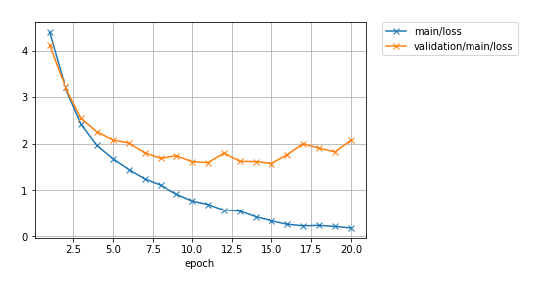

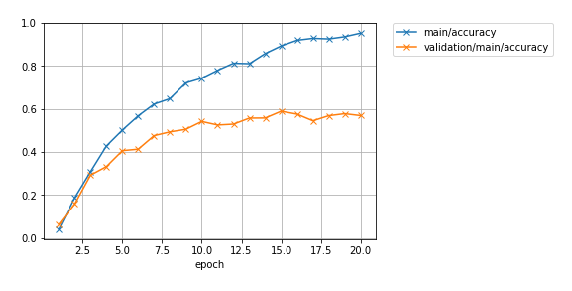

In [305]:
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()
#損失関数と精度の視覚化    
show_graph('result/loss.png')
show_graph('result/accuracy.png')


In [306]:
#modelの保存
serializers.save_npz('leaf_classification_model', model)

In [25]:
#modelの読み込み
serializers.load_npz('leaf_classification_model', model)

In [26]:
#提出用の画像データの読み込み
predict_images = []
for i in test_.id:
    image = cv2.imread('images3/%d.jpg' % i)
    grayed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    predict_images.append(grayed)
    

In [27]:
predict_length = len(predict_images)
predict_images = np.array([predict_images])

#chaienrが扱える形に大きさを変換する。
predict_images = predict_images.reshape((predict_length, 1, 32, 32))
print(predict_images.shape)

(594, 1, 32, 32)


In [28]:
#chainerが扱える形に変換
predict_images = predict_images.astype(np.float32)

In [29]:
predict_label = []
#予測する関数
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred = model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

pred = predict(model, predict_images)

In [30]:
#得られたラベルを元のspeciesに戻す。
predic_label = le.inverse_transform(pred)
predic_label[:5]

C:\Users\falcon4842\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Quercus_Agrifolia', 'Eucalyptus_Urnigera', 'Acer_Circinatum',
       'Quercus_Castaneifolia', 'Populus_Grandidentata'], dtype=object)

In [31]:
df_test_id = pd.DataFrame(test_.id, columns=['id'])
df_test_pred = pd.DataFrame(predic_label, columns=['species'])
#kaggleの評価は、それぞれのspeciesでの確率なのでダミー変数化しておく。0か1で確率表現ができる。
df_test_pred_dummy = pd.get_dummies(df_test_pred['species'])
df_submit = pd.concat([df_test_id, df_test_pred_dummy], axis=1)
df_submit.to_csv('leaf_classification2.csv', index=False)